In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import kagglehub

# Kaggle 데이터 다운로드
path = kagglehub.dataset_download("zeyadkhalid/mbti-personality-types-500-dataset")
print("Path to dataset files:", path)

# 데이터 로드 및 전처리
df = pd.read_csv(f"{path}/MBTI 500.csv")
df = df.dropna(subset=['type', 'posts'])

# TF-IDF 변환
vectorizer = TfidfVectorizer(max_features=1000, max_df=0.9)
X = vectorizer.fit_transform(df['posts']).toarray()

# 각 차원별 레이블 생성
df['I_E'] = df['type'].apply(lambda x: 1 if x[0] == 'E' else 0)
df['N_S'] = df['type'].apply(lambda x: 1 if x[1] == 'S' else 0)
df['T_F'] = df['type'].apply(lambda x: 1 if x[2] == 'F' else 0)
df['J_P'] = df['type'].apply(lambda x: 1 if x[3] == 'P' else 0)

# DownSampling 함수 정의
def downsample(df, target_col):
    minority_class_size = df[target_col].value_counts().min()
    df_majority = df[df[target_col] == df[target_col].value_counts().idxmax()]
    df_minority = df[df[target_col] == df[target_col].value_counts().idxmin()]
    df_majority_downsampled = resample(
        df_majority,
        replace=False,
        n_samples=minority_class_size,
        random_state=42
    )
    df_balanced = pd.concat([df_majority_downsampled, df_minority])
    return df_balanced

# 각 차원별 DownSampling 수행
df_ie_balanced = downsample(df, 'I_E')
df_ns_balanced = downsample(df, 'N_S')
df_tf_balanced = downsample(df, 'T_F')
df_jp_balanced = downsample(df, 'J_P')

# DownSampling 후 데이터 확인
print("I_E Balance:\n", df_ie_balanced['I_E'].value_counts())
print("N_S Balance:\n", df_ns_balanced['N_S'].value_counts())
print("T_F Balance:\n", df_tf_balanced['T_F'].value_counts())
print("J_P Balance:\n", df_jp_balanced['J_P'].value_counts())

# 학습 및 평가 함수 정의
def train_and_predict(X_train, y_train, X_test, y_test, label):
    # GPU 활성화: tree_method='gpu_hist'
    model = XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        tree_method='gpu_hist',  # GPU 활성화
        learning_rate=0.1,
        n_estimators=500,
        max_depth=10
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy for {label}: {accuracy}")
    return model

# 각 차원별 데이터 분할 및 모델 학습
def prepare_and_train(df_balanced, label):
    X_balanced = vectorizer.transform(df_balanced['posts']).toarray()
    y_balanced = df_balanced[label]
    X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)
    model = train_and_predict(X_train, y_train, X_test, y_test, label)
    return model, X_test, y_test

model_ie, X_test_ie, y_test_ie = prepare_and_train(df_ie_balanced, 'I_E')
model_ns, X_test_ns, y_test_ns = prepare_and_train(df_ns_balanced, 'N_S')
model_tf, X_test_tf, y_test_tf = prepare_and_train(df_tf_balanced, 'T_F')
model_jp, X_test_jp, y_test_jp = prepare_and_train(df_jp_balanced, 'J_P')

# 최종 MBTI 예측 함수 정의
def calculate_final_accuracy(X_test, y_test_full):
    predictions = []
    for x in X_test:
        x = x.reshape(1, -1)
        ie = 'E' if model_ie.predict(x)[0] == 1 else 'I'
        ns = 'S' if model_ns.predict(x)[0] == 1 else 'N'
        tf = 'F' if model_tf.predict(x)[0] == 1 else 'T'
        jp = 'P' if model_jp.predict(x)[0] == 1 else 'J'
        predictions.append(ie + ns + tf + jp)

    correct_predictions = sum([1 for true, pred in zip(y_test_full, predictions) if true == pred])
    final_accuracy = correct_predictions / len(y_test_full)
    return final_accuracy

# 전체 MBTI 유형 데이터로 예측
X_full_test, y_full_test = vectorizer.transform(df['posts']).toarray(), df['type']
final_accuracy = calculate_final_accuracy(X_full_test, y_full_test)
print("Final MBTI Prediction Accuracy:", final_accuracy)

# 샘플 텍스트 예측
def predict_mbti(text):
    x = vectorizer.transform([text]).toarray()
    ie = 'E' if model_ie.predict(x)[0] == 1 else 'I'
    ns = 'S' if model_ns.predict(x)[0] == 1 else 'N'
    tf = 'F' if model_tf.predict(x)[0] == 1 else 'T'
    jp = 'P' if model_jp.predict(x)[0] == 1 else 'J'
    return ie + ns + tf + jp

sample_text = "I enjoy deep conversations and reflecting on philosophical topics."
predicted_mbti = predict_mbti(sample_text)
print("Predicted MBTI:", predicted_mbti)


Path to dataset files: /root/.cache/kagglehub/datasets/zeyadkhalid/mbti-personality-types-500-dataset/versions/1
I_E Balance:
 I_E
0    25390
1    25390
Name: count, dtype: int64
N_S Balance:
 N_S
0    9201
1    9201
Name: count, dtype: int64
T_F Balance:
 T_F
0    36864
1    36864
Name: count, dtype: int64
J_P Balance:
 J_P
1    44435
0    44435
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:41:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:42:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:42:53] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.


Accuracy for I_E: 0.8718983851910201


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:43:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:43:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Accuracy for N_S: 0.8918772072806302


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:44:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:45:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Accuracy for T_F: 0.9073647090736471


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:46:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:47:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Accuracy for J_P: 0.8693597389445257
Final MBTI Prediction Accuracy: 0.7748215750421903
Predicted MBTI: ISTJ


In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# WordCloud를 생성하는 함수
def generate_wordcloud(text_data, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(text_data))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=20)
    plt.axis("off")
    plt.show()

# 각 MBTI 차원별 WordCloud 생성
def create_wordclouds_for_mbti_dimensions(df):
    # I vs E
    introvert_text = df[df['I_E'] == 0]['posts']
    extrovert_text = df[df['I_E'] == 1]['posts']
    generate_wordcloud(introvert_text, "Word Cloud for I (Introverted) People")
    generate_wordcloud(extrovert_text, "Word Cloud for E (Extraverted) People")

    # N vs S
    intuitive_text = df[df['N_S'] == 0]['posts']
    sensing_text = df[df['N_S'] == 1]['posts']
    generate_wordcloud(intuitive_text, "Word Cloud for N (Intuitive) People")
    generate_wordcloud(sensing_text, "Word Cloud for S (Sensing) People")

    # T vs F
    thinking_text = df[df['T_F'] == 0]['posts']
    feeling_text = df[df['T_F'] == 1]['posts']
    generate_wordcloud(thinking_text, "Word Cloud for T (Thinking) People")
    generate_wordcloud(feeling_text, "Word Cloud for F (Feeling) People")

    # J vs P
    judging_text = df[df['J_P'] == 0]['posts']
    perceiving_text = df[df['J_P'] == 1]['posts']
    generate_wordcloud(judging_text, "Word Cloud for J (Judging) People")
    generate_wordcloud(perceiving_text, "Word Cloud for P (Perceiving) People")

# WordCloud 생성 실행
create_wordclouds_for_mbti_dimensions(df)


In [ ]:
import cupy as cp
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# WordCloud 라이브러리에 cupy를 사용해 GPU 최적화
class GPUWordCloud(WordCloud):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def fit_words(self, frequencies):
        """
        Override `fit_words` to use CuPy arrays for GPU acceleration
        """
        frequencies = cp.array(list(frequencies.items()))
        result = super().fit_words(frequencies.get())
        return result

# GPU WordCloud 생성 함수
def generate_gpu_wordcloud(text_data, title):
    wordcloud = GPUWordCloud(width=800, height=400, background_color='white').generate(" ".join(text_data))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=20)
    plt.axis("off")
    plt.show()

# I (Introverted) vs E (Extraverted) WordCloud 생성 예제
introverted_posts = df[df['I_E'] == 0]['posts']
extroverted_posts = df[df['I_E'] == 1]['posts']

generate_gpu_wordcloud(introverted_posts, "GPU Accelerated Word Cloud for Introverts")
generate_gpu_wordcloud(extroverted_posts, "GPU Accelerated Word Cloud for Extroverts")


NameError: name 'df' is not defined

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import kagglehub

# Kaggle 데이터 다운로드
path = kagglehub.dataset_download("zeyadkhalid/mbti-personality-types-500-dataset")
print("Path to dataset files:", path)

# 데이터 로드 및 전처리
df = pd.read_csv(f"{path}/MBTI 500.csv")
df = df.dropna(subset=['type', 'posts'])

# TF-IDF 변환
vectorizer = TfidfVectorizer(max_features=1000, max_df=0.9)
X = vectorizer.fit_transform(df['posts']).toarray()

# 각 차원별 레이블 생성
df['I_E'] = df['type'].apply(lambda x: 1 if x[0] == 'E' else 0)
df['N_S'] = df['type'].apply(lambda x: 1 if x[1] == 'S' else 0)
df['T_F'] = df['type'].apply(lambda x: 1 if x[2] == 'F' else 0)
df['J_P'] = df['type'].apply(lambda x: 1 if x[3] == 'P' else 0)

# DownSampling 함수 정의
def downsample(df, target_col):
    minority_class_size = df[target_col].value_counts().min()
    df_majority = df[df[target_col] == df[target_col].value_counts().idxmax()]
    df_minority = df[df[target_col] == df[target_col].value_counts().idxmin()]
    df_majority_downsampled = resample(
        df_majority,
        replace=False,
        n_samples=minority_class_size,
        random_state=42
    )
    df_balanced = pd.concat([df_majority_downsampled, df_minority])
    return df_balanced

# 각 차원별 DownSampling 수행
df_ie_balanced = downsample(df, 'I_E')
df_ns_balanced = downsample(df, 'N_S')
df_tf_balanced = downsample(df, 'T_F')
df_jp_balanced = downsample(df, 'J_P')

# DownSampling 후 데이터 확인
print("I_E Balance:\n", df_ie_balanced['I_E'].value_counts())
print("N_S Balance:\n", df_ns_balanced['N_S'].value_counts())
print("T_F Balance:\n", df_tf_balanced['T_F'].value_counts())
print("J_P Balance:\n", df_jp_balanced['J_P'].value_counts())

# 학습 및 평가 함수 정의
def train_and_predict(X_train, y_train, X_test, y_test, label):
    # GPU 활성화: tree_method='gpu_hist'
    model = XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        tree_method='gpu_hist',  # GPU 활성화
        learning_rate=0.1,
        n_estimators=500,
        max_depth=10
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy for {label}: {accuracy}")
    return model

# 각 차원별 데이터 분할 및 모델 학습
def prepare_and_train(df_balanced, label):
    X_balanced = vectorizer.transform(df_balanced['posts']).toarray()
    y_balanced = df_balanced[label]
    X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)
    model = train_and_predict(X_train, y_train, X_test, y_test, label)
    return model, X_test, y_test

model_ie, X_test_ie, y_test_ie = prepare_and_train(df_ie_balanced, 'I_E')
model_ns, X_test_ns, y_test_ns = prepare_and_train(df_ns_balanced, 'N_S')
model_tf, X_test_tf, y_test_tf = prepare_and_train(df_tf_balanced, 'T_F')
model_jp, X_test_jp, y_test_jp = prepare_and_train(df_jp_balanced, 'J_P')

# 최종 MBTI 예측 함수 정의
def calculate_final_accuracy(X_test, y_test_full):
    predictions = []
    for x in X_test:
        x = x.reshape(1, -1)
        ie = 'E' if model_ie.predict(x)[0] == 1 else 'I'
        ns = 'S' if model_ns.predict(x)[0] == 1 else 'N'
        tf = 'F' if model_tf.predict(x)[0] == 1 else 'T'
        jp = 'P' if model_jp.predict(x)[0] == 1 else 'J'
        predictions.append(ie + ns + tf + jp)

    correct_predictions = sum([1 for true, pred in zip(y_test_full, predictions) if true == pred])
    final_accuracy = correct_predictions / len(y_test_full)
    return final_accuracy

# 전체 MBTI 유형 데이터로 예측
X_full_test, y_full_test = vectorizer.transform(df['posts']).toarray(), df['type']
final_accuracy = calculate_final_accuracy(X_full_test, y_full_test)
print("Final MBTI Prediction Accuracy:", final_accuracy)

# 샘플 텍스트 예측
def predict_mbti(text):
    x = vectorizer.transform([text]).toarray()
    ie = 'E' if model_ie.predict(x)[0] == 1 else 'I'
    ns = 'S' if model_ns.predict(x)[0] == 1 else 'N'
    tf = 'F' if model_tf.predict(x)[0] == 1 else 'T'
    jp = 'P' if model_jp.predict(x)[0] == 1 else 'J'
    return ie + ns + tf + jp

sample_text = "I enjoy deep conversations and reflecting on philosophical topics."
predicted_mbti = predict_mbti(sample_text)
print("Predicted MBTI:", predicted_mbti)


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import kagglehub

# Kaggle 데이터 다운로드
path = kagglehub.dataset_download("zeyadkhalid/mbti-personality-types-500-dataset")
print("Path to dataset files:", path)

# 데이터 로드 및 전처리
df = pd.read_csv(f"{path}/MBTI 500.csv")
df = df.dropna(subset=['type', 'posts'])

# TF-IDF 변환
vectorizer = TfidfVectorizer(max_features=1000, max_df=0.9)
X = vectorizer.fit_transform(df['posts']).toarray()

# 각 차원별 레이블 생성
df['I_E'] = df['type'].apply(lambda x: 1 if x[0] == 'E' else 0)
df['N_S'] = df['type'].apply(lambda x: 1 if x[1] == 'S' else 0)
df['T_F'] = df['type'].apply(lambda x: 1 if x[2] == 'F' else 0)
df['J_P'] = df['type'].apply(lambda x: 1 if x[3] == 'P' else 0)

# DownSampling 함수 정의
def downsample(df, target_col):
    minority_class_size = df[target_col].value_counts().min()
    df_majority = df[df[target_col] == df[target_col].value_counts().idxmax()]
    df_minority = df[df[target_col] == df[target_col].value_counts().idxmin()]
    df_majority_downsampled = resample(
        df_majority,
        replace=False,
        n_samples=minority_class_size,
        random_state=42
    )
    df_balanced = pd.concat([df_majority_downsampled, df_minority])
    return df_balanced

# 각 차원별 DownSampling 수행
df_ie_balanced = downsample(df, 'I_E')
df_ns_balanced = downsample(df, 'N_S')
df_tf_balanced = downsample(df, 'T_F')
df_jp_balanced = downsample(df, 'J_P')

# DownSampling 후 데이터 확인
print("I_E Balance:\n", df_ie_balanced['I_E'].value_counts())
print("N_S Balance:\n", df_ns_balanced['N_S'].value_counts())
print("T_F Balance:\n", df_tf_balanced['T_F'].value_counts())
print("J_P Balance:\n", df_jp_balanced['J_P'].value_counts())

# 학습 및 평가 함수 정의
def train_and_predict(X_train, y_train, X_test, y_test, label):
    # GPU 활성화: tree_method='gpu_hist'
    model = XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        tree_method='gpu_hist',  # GPU 활성화
        learning_rate=0.1,
        n_estimators=200,
        max_depth=10
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy for {label}: {accuracy}")
    return model

# 각 차원별 데이터 분할 및 모델 학습
def prepare_and_train(df_balanced, label):
    X_balanced = vectorizer.transform(df_balanced['posts']).toarray()
    y_balanced = df_balanced[label]
    X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)
    model = train_and_predict(X_train, y_train, X_test, y_test, label)
    return model, X_test, y_test

model_ie, X_test_ie, y_test_ie = prepare_and_train(df_ie_balanced, 'I_E')
model_ns, X_test_ns, y_test_ns = prepare_and_train(df_ns_balanced, 'N_S')
model_tf, X_test_tf, y_test_tf = prepare_and_train(df_tf_balanced, 'T_F')
model_jp, X_test_jp, y_test_jp = prepare_and_train(df_jp_balanced, 'J_P')

# 최종 MBTI 예측 함수 정의
def calculate_final_accuracy(X_test, y_test_full):
    predictions = []
    for x in X_test:
        x = x.reshape(1, -1)
        ie = 'E' if model_ie.predict(x)[0] == 1 else 'I'
        ns = 'S' if model_ns.predict(x)[0] == 1 else 'N'
        tf = 'F' if model_tf.predict(x)[0] == 1 else 'T'
        jp = 'P' if model_jp.predict(x)[0] == 1 else 'J'
        predictions.append(ie + ns + tf + jp)

    correct_predictions = sum([1 for true, pred in zip(y_test_full, predictions) if true == pred])
    final_accuracy = correct_predictions / len(y_test_full)
    return final_accuracy

# 전체 MBTI 유형 데이터로 예측
X_full_test, y_full_test = vectorizer.transform(df['posts']).toarray(), df['type']
final_accuracy = calculate_final_accuracy(X_full_test, y_full_test)
print("Final MBTI Prediction Accuracy:", final_accuracy)

# 샘플 텍스트 예측
def predict_mbti(text):
    x = vectorizer.transform([text]).toarray()
    ie = 'E' if model_ie.predict(x)[0] == 1 else 'I'
    ns = 'S' if model_ns.predict(x)[0] == 1 else 'N'
    tf = 'F' if model_tf.predict(x)[0] == 1 else 'T'
    jp = 'P' if model_jp.predict(x)[0] == 1 else 'J'
    return ie + ns + tf + jp

sample_text = "I enjoy deep conversations and reflecting on philosophical topics."
predicted_mbti = predict_mbti(sample_text)
print("Predicted MBTI:", predicted_mbti)


Path to dataset files: /root/.cache/kagglehub/datasets/zeyadkhalid/mbti-personality-types-500-dataset/versions/1
I_E Balance:
 I_E
0    25390
1    25390
Name: count, dtype: int64
N_S Balance:
 N_S
0    9201
1    9201
Name: count, dtype: int64
T_F Balance:
 T_F
0    36864
1    36864
Name: count, dtype: int64
J_P Balance:
 J_P
1    44435
0    44435
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:44:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:45:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:45:29] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.


Accuracy for I_E: 0.8633320204805042


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:45:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:45:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Accuracy for N_S: 0.8864439011138278


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:46:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:47:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Accuracy for T_F: 0.9005832090058321


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:47:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:48:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Accuracy for J_P: 0.86345223359964
Final MBTI Prediction Accuracy: 0.7603590183563219
Predicted MBTI: ISTJ


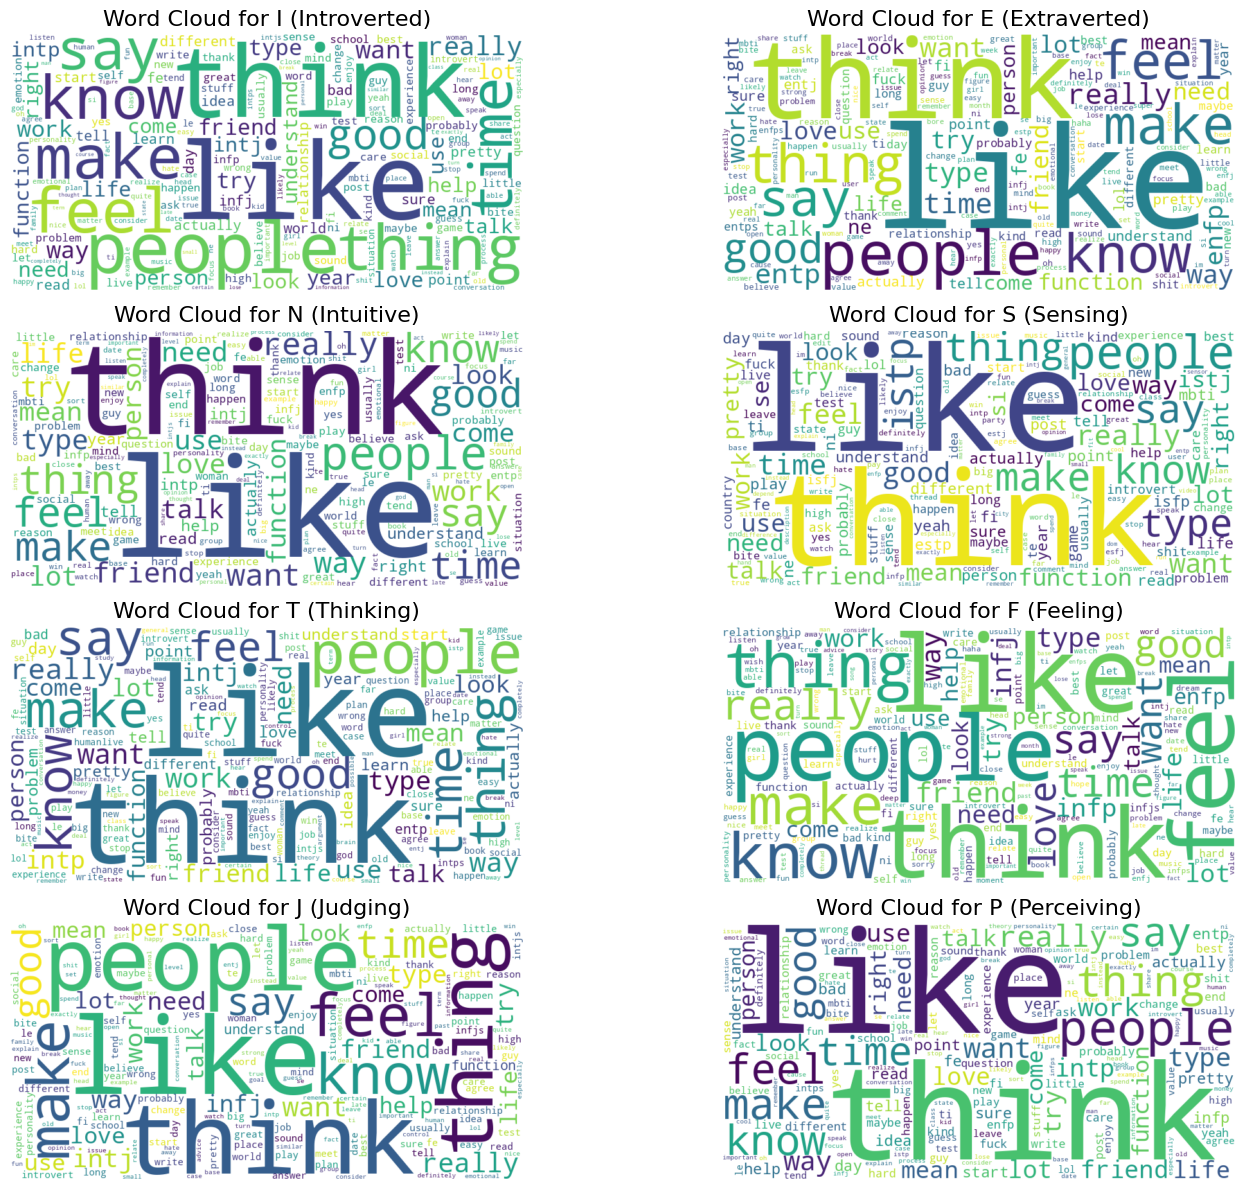

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# 데이터 준비: df는 MBTI 데이터프레임이어야 합니다.
# 예: df['posts'], df['type'] 열이 포함되어 있어야 합니다.

# TF-IDF 벡터화
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(df['posts'])
feature_names = vectorizer.get_feature_names_out()

# 각 차원의 상대 빈도 계산 함수
def calculate_relative_frequency(df, dimension_label, dimension_value):
    posts = " ".join(df[df[dimension_label] == dimension_value]['posts'])
    word_freq = vectorizer.transform([posts]).toarray().flatten()
    return word_freq

# 각 차원의 빈도 계산
df['I_E'] = df['type'].apply(lambda x: 1 if x[0] == 'E' else 0)
df['N_S'] = df['type'].apply(lambda x: 1 if x[1] == 'S' else 0)
df['T_F'] = df['type'].apply(lambda x: 1 if x[2] == 'F' else 0)
df['J_P'] = df['type'].apply(lambda x: 1 if x[3] == 'P' else 0)

# WordCloud 생성을 위한 상대 빈도 데이터프레임
df_freq = pd.DataFrame({
    'non_zero_feature_names': feature_names,
    'i_relative_frequency': calculate_relative_frequency(df, 'I_E', 0),
    'e_relative_frequency': calculate_relative_frequency(df, 'I_E', 1),
    'n_relative_frequency': calculate_relative_frequency(df, 'N_S', 0),
    's_relative_frequency': calculate_relative_frequency(df, 'N_S', 1),
    't_relative_frequency': calculate_relative_frequency(df, 'T_F', 0),
    'f_relative_frequency': calculate_relative_frequency(df, 'T_F', 1),
    'j_relative_frequency': calculate_relative_frequency(df, 'J_P', 0),
    'p_relative_frequency': calculate_relative_frequency(df, 'J_P', 1),
}).set_index('non_zero_feature_names')

# WordCloud 생성 함수
def generate_wordcloud(relative_frequency, title):
    wordcloud_data = relative_frequency.to_dict()
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(wordcloud_data)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=16)
    plt.axis('off')

# 모든 차원별 WordCloud 생성 및 시각화
plt.figure(figsize=(16, 12))

# I/E
plt.subplot(4, 2, 1)
generate_wordcloud(df_freq['i_relative_frequency'], "Word Cloud for I (Introverted)")
plt.subplot(4, 2, 2)
generate_wordcloud(df_freq['e_relative_frequency'], "Word Cloud for E (Extraverted)")

# N/S
plt.subplot(4, 2, 3)
generate_wordcloud(df_freq['n_relative_frequency'], "Word Cloud for N (Intuitive)")
plt.subplot(4, 2, 4)
generate_wordcloud(df_freq['s_relative_frequency'], "Word Cloud for S (Sensing)")

# T/F
plt.subplot(4, 2, 5)
generate_wordcloud(df_freq['t_relative_frequency'], "Word Cloud for T (Thinking)")
plt.subplot(4, 2, 6)
generate_wordcloud(df_freq['f_relative_frequency'], "Word Cloud for F (Feeling)")

# J/P
plt.subplot(4, 2, 7)
generate_wordcloud(df_freq['j_relative_frequency'], "Word Cloud for J (Judging)")
plt.subplot(4, 2, 8)
generate_wordcloud(df_freq['p_relative_frequency'], "Word Cloud for P (Perceiving)")

plt.tight_layout()
plt.show()
